# Super_Resolution_CNN(SRCNN)

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

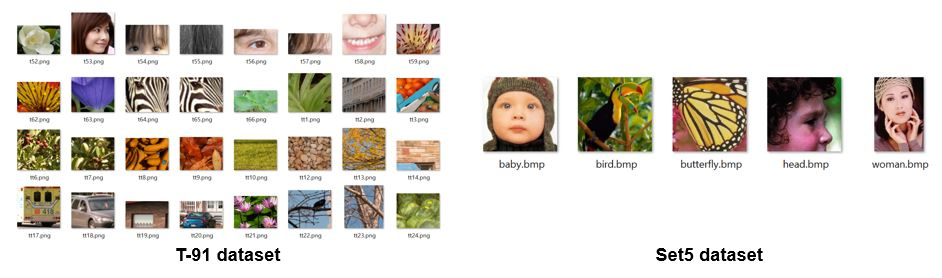

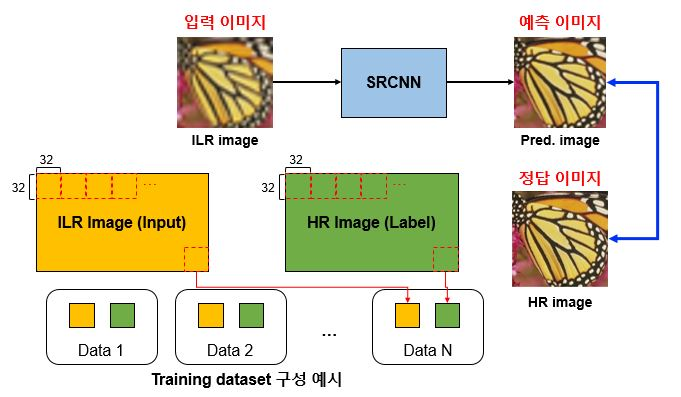

LR(Low Resolution)Down sampling

ILR(Interpolated LR)Bi-cubic

HR(Origianl image High REsolution)


### 폴더 경로 저장

In [ ]:
datasetPath = "./drive/MyDrive/dataset/"
parameterPath = "./drive/MyDrive/parameters/"

### 패키지 선언

In [ ]:
import torch
import torch.nn as nn
import torchvision.datasets as dataset
import torchvision.transforms as transform
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from glob import glob
import numpy as np
import cv2

## DataLoader 정의

In [ ]:
# Training data loader
class TrainDataset(Dataset):
    def __init__(self):
        patch_size = 32

        # 다운로드 받은 모든 이미지 경로 가져오기
        inputImgPaths = glob(datasetPath+"SR_dataset/T91_ILR/*.png")
        labelImgPaths = glob(datasetPath+"SR_dataset/T91_HR/*.png")
        inputImgPaths.sort()
        labelImgPaths.sort()

        # 데이터 (패치)를 저장할 리스트 생성
        self.inputPatchs = []
        self.labelPatchs = []

        for idx in range(len(inputImgPaths)):
            # 한개 이미지 읽고 정규화 수행
            inputImg = np.array(cv2.imread(inputImgPaths[idx]), dtype=np.float32) / 255.
            labelImg = np.array(cv2.imread(labelImgPaths[idx]), dtype=np.float32) / 255.

            inputImg = np.transpose(inputImg, [2, 0, 1]) # 이미지 차원 변경
            labelImg = np.transpose(labelImg, [2, 0, 1]) # [H x W x C] -> [C x H x W]

            # 한개 이미지를 여러개의 패치로 변경
            self.frameToPatchs(inputImg, labelImg, patch_size)

    def __len__(self):
        return len(self.inputPatchs)

    def __getitem__(self, idx):
        return self.inputPatchs[idx], self.labelPatchs[idx]

    def frameToPatchs (self, inputImg=None, labelImg=None, patch_size=32):
        channel, height, width = labelImg.shape

        numPatchY = height // patch_size
        numPatchX = width // patch_size

        for yIdx in range(numPatchY):
            for xIdx in range(numPatchX):
                xStartPos = xIdx * patch_size
                xFinalPos = xStartPos + patch_size
                yStartPos = yIdx * patch_size
                yFinalPos = yStartPos + patch_size

                self.inputPatchs.append(inputImg[:, yStartPos:yFinalPos, xStartPos:xFinalPos])
                self.labelPatchs.append(labelImg[:, yStartPos:yFinalPos, xStartPos:xFinalPos])

In [ ]:
# Testing data loader
class TestDataset(Dataset):
    def __init__(self):
        patch_size = 32

        # 다운로드 받은 모든 이미지 경로 가져오기
        inputImgPaths = glob(datasetPath+"SR_dataset/Set5_ILR/*.bmp")
        labelImgPaths = glob(datasetPath+"SR_dataset/Set5_HR/*.bmp")
        inputImgPaths.sort()
        labelImgPaths.sort()

        # 데이터를 저장할 리스트 생성
        self.inputImgs = []
        self.labelImgs = []
        self.imgNames = []

        for idx in range(len(inputImgPaths)):
            # 한개 이미지 읽고 정규화 수행
            inputImg = np.array(cv2.imread(inputImgPaths[idx]), dtype=np.float32) / 255.
            labelImg = np.array(cv2.imread(labelImgPaths[idx]), dtype=np.float32) / 255.

            inputImg = np.transpose(inputImg, [2, 0, 1]) # 이미지 차원 변경
            labelImg = np.transpose(labelImg, [2, 0, 1]) # [H x W x C] -> [C x H x W]

            # 이미지 패치를 수행하지 않고 그대로 저장
            self.inputImgs.append(inputImg)
            self.labelImgs.append(labelImg)
            self.imgNames.append(inputImgPaths[idx].split("/")[-1])

    def __len__(self):
        return len(self.inputImgs)

    def __getitem__(self, idx):
        return self.inputImgs[idx], self.labelImgs[idx], self.imgNames[idx]



## SRCNN 모델 정의

In [ ]:
class SRCNN (nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=9, padding=4)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=9, padding=4)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=5, padding=2)
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=1, padding=0)
        self.conv6 = nn.Conv2d(in_channels=32, out_channels=3, kernel_size=5, padding=2)
        self.relu = nn.ReLU()

    def forward(self, x):

        out = self.relu(self.conv1(x))
        out = self.relu(self.conv2(out))
        out = self.relu(self.conv3(out))
        out = self.relu(self.conv4(out))
        out = self.relu(self.conv5(out))
        out = self.conv6(out)
        return out

## Hyper-parameters 지정

In [ ]:
network = SRCNN()
training_epoch = 100
batch_size = 4
base_learning_rate = 1e-3 #0.001
loss_function = nn.MSELoss()

optimizer = torch.optim.Adam([{'params':network.conv1.parameters()},
                            {'params':network.conv2.parameters()},
                            {'params':network.conv3.parameters(), 'lr':base_learning_rate * 0.1}],
                            lr = base_learning_rate)

train_dataset = TrainDataset()
train_dataloader = DataLoader(dataset = train_dataset,
                              batch_size = batch_size,
                              shuffle = True,
                              drop_last = True)

KeyboardInterrupt: ignored

## Training loop w/ GPU
- Colab 상단 런타임 - 런타임 유형 변경 - 하드웨어 가속기 에서 GPU 선택 - 저장
- !nvidia-smi 명령어로 GPU 할당 여부 확인
- network parameter 및 data 유형을 cuda:0으로 설정

In [ ]:
!nvidia-smi

In [ ]:
network.train()
network = network.to('cuda:0')
for epoch in range(training_epoch):
    avg_cost = 0
    total_batch = len(train_dataloader)

    for inputImg, labelImg in train_dataloader:

        inputImg = inputImg.to('cuda:0')
        labelImg = labelImg.to('cuda:0')

        predImg = network(inputImg)

        loss = loss_function(predImg, labelImg)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_cost += loss / total_batch

    print('Epoch: %d Loss = %f'%(epoch+1, avg_cost))

print('Learning finished')

Parameter 저장

In [ ]:
torch.save(network.state_dict(), parameterPath+"SRCNN.pth")

## PSNR 계산 함수 정의

In [ ]:
def calc_psnr(origImg, predImg):
    return 10. * torch.log10(1. / torch.mean((origImg - predImg)**2))

## 이미지 복원 품질 측정 및 저장

In [ ]:
test_dataset = TestDataset()
test_dataloader = DataLoader(dataset = test_dataset, batch_size = 1)
bicubic_PSNRs = []
srcnn_PSNRs = []

network.eval()
network = network.to('cpu')

for inputImg, labelImg, imgName in test_dataloader:

    with torch.no_grad():
        predImg = network(inputImg).clamp(0.0, 1.0)

    bicubic_PSNRs.append(calc_psnr(labelImg, inputImg))
    srcnn_PSNRs.append(calc_psnr(labelImg, predImg))

    predImg = np.array(predImg * 255, dtype=np.uint8)
    predImg = np.transpose(predImg[0,:,:,:], [1, 2, 0])
    cv2.imwrite(datasetPath+"SR_dataset/Set5_Pred/"+imgName[0], predImg) # 복원된 이미지 저장

print('Average PSNR (bicuic)\t: %.4fdB'%(sum(bicubic_PSNRs)/len(bicubic_PSNRs)))
print('Average PSNR (SRCNN)\t: %.4fdB'%(sum(srcnn_PSNRs)/len(srcnn_PSNRs)))


## Torchsummary 패키지를 사용해 SRCNN 복잡도 측정

In [ ]:
from torchsummary import summary
inChannel = 3
inWidth = 32
inHeight = 32

summary(SRCNN(),input_size=(inChannel, inWidth, inHeight), device='cpu')